<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_01/blob/main/Reto_1_M09_Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 1** - (Notebook 2/5)
Autores: **Meysam Madadi** & **Julio C. S. Jacques Junior**

---

# **Prerrequisitos**
- Consultar las instrucciones en los *Jupyter notebooks* anteriores.
- Ejecutar los *Jupyter notebooks* anteriores, en este caso:
 - *Jupyter notebook* 1.

# **Los objetivos de este Jupyter notebook**
- Cargar los datos guardados en nuestro Google Drive;
- Entrenar nuestra red (ResNet) desde cero (es decir, ignorando los pesos pre-entrenados);
- Visualizar los resultados.
---

## Comprobando la versión de tensorflow

In [1]:
# Este código fue probado en tensorflow 2.15.0
# Por algún motivo la versión actual es 2.17.0 , ya que nos dió errores en el primer notebook forzamos la instalacion de la versión 2.15.0 de nuevo
!pip install tensorflow==2.15.0
import tensorflow as tf
print(tf.__version__)

2.15.0


# Montando nuestro Google Drive para guardar/cargar nuestros resultados

In [2]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/M09-P01/' as I
  # created a '/M09-P01/' folder in my google drive for this purpose.

Mounted at /content/gdrive


# Cargando el modelo y los datos preprocesados desde Drive

In [3]:
import numpy as np
import tensorflow as tf

with open('/content/gdrive/MyDrive/M09-P01/train.npy', 'rb') as f:
  X_train = np.load(f)
  Y_train = np.load(f)
  M_train = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/valid.npy', 'rb') as f:
  X_valid = np.load(f)
  Y_valid = np.load(f)
  M_valid = np.load(f)
with open('/content/gdrive/MyDrive/M09-P01/test.npy', 'rb') as f:
  X_test = np.load(f)
  Y_test = np.load(f)
  M_test = np.load(f)

model = tf.keras.models.load_model('/content/gdrive/MyDrive/M09-P01/init_model.h5')


##############################################################
# creating a newly initialized model to train from scratch
#
model_from_scratch = tf.keras.models.clone_model(model)
#
##############################################################

# **Entrenando la red desde cero**
- El entrenamiento desde cero significa que **los pesos de la red se inicializan aleatoriamente**. Es decir, estamos usando una ResNet como arquitectura principal (o, como se dice, "backbone"), pero **no estamos haciendo ningún aprendizaje por transferencia**.
- A continuación, definimos el **optimizador**, la **función de pérdida**, las **métricas**, y construimos e iniciamos el **ciclo de entrenamiento** utilizando la función "fit".
- Por último, evaluamos el modelo en el conjunto de prueba y guardamos el historial y el mejor modelo en nuestro Goodl Drive.
 - Usamos el **error cuadrático medio (MSE) como función de pérdida** ('loss=tf.keras.losses.MeanSquaredError()'). El código también evalúa el error absoluto medio (MAE) durante el entrenamiento ('metrics=['mae']'). **La tasa de aprendizaje** se establece en 'learning_rate=1e-4', el **tamaño del lote** (batch size) = 32, y el modelo se entrenará durante 20 **epochs** (si Colab lo permite en función de los recursos disponibles).
 - El código está configurado para **guardar el mejor modelo** (save_best_only=True) **basado en "valid_loss"** (monitor='val_loss'). Es decir, si la pérdida de validación disminuye, en comparación con el modelo guardado anteriormente, se guarda un nuevo modelo en la ruta que hemos definimos.
 - Utilizamos **early stopping para evitar el sobreajuste**. Es decir, el modelo dejará de entrenarse si no se observa ninguna mejora en los últimos N=5 *epochs*.



In [5]:
  import pickle

  # defining the early stopping criteria
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/M09-P01/best_model_from_scratch.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model_from_scratch.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model_from_scratch.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/M09-P01/train_history_from_scratch.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/50
94/94 [==============================] - 103s 805ms/step - loss: 0.0307 - mae: 0.1172 - val_loss: 0.1242 - val_mae: 0.2958
Epoch 2/50
94/94 [==============================] - 80s 858ms/step - loss: 0.0308 - mae: 0.1165 - val_loss: 0.0318 - val_mae: 0.1155
Epoch 3/50
94/94 [==============================] - 46s 484ms/step - loss: 0.0302 - mae: 0.1165 - val_loss: 0.0308 - val_mae: 0.1151
Epoch 4/50
94/94 [==============================] - 58s 622ms/step - loss: 0.0316 - mae: 0.1162 - val_loss: 0.0270 - val_mae: 0.1145
Epoch 5/50
94/94 [==============================] - 30s 320ms/step - loss: 0.0314 - mae: 0.1149 - val_loss: 0.0292 - val_mae: 0.1161
Epoch 6/50
28/94 [=======>......................] - ETA: 19s - loss: 0.0292 - mae: 0.1137

KeyboardInterrupt: 

# Visualizando la curva de entrenamiento

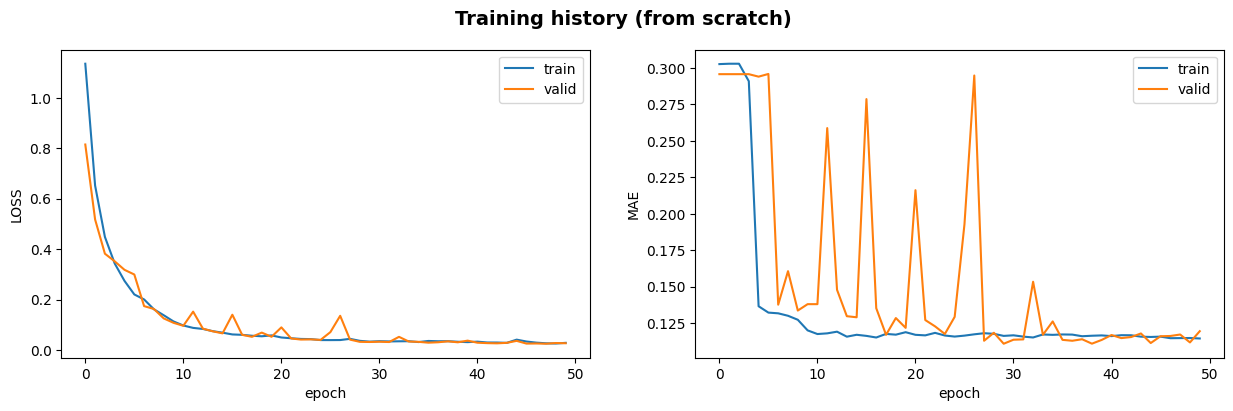

In [6]:
from matplotlib import pyplot as plt

# here, it loads the history of the model you trained before
train_hist = pickle.load(open('/content/gdrive/MyDrive/M09-P01/train_history_from_scratch.pkl',"rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (from scratch)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# Evaluando el modelo entrenado en el conjunto de prueba

In [7]:
# loading the (best) saved model
model_from_scratch = tf.keras.models.load_model('/content/gdrive/MyDrive/M09-P01/best_model_from_scratch.h5')

# Evaluate the trained model on the test set
print('Evaluating on the test set')
predictions = model_from_scratch.predict(X_test, batch_size=32, verbose=1)

# Computing the Mean Absolute Error
# Also re-scaling the values to the range of "age" as the are in the range of [0,1]
mae = np.mean(abs(predictions[:,0] - Y_test)*100)

# Next, we print the average error. Note that the error is rescaled back to the range [0-100]
print('\nThe final mean absolute error (on the Test set)  is ' + str(mae) + ' years old.')

Evaluating on the test set
32/32 [==============================] - 4s 78ms/step

The final mean absolute error (on the Test set)  is 13.437603393355307 years old.


# Imprimiendo algunas predicciones generadas

In [8]:
# printing some predictions and re-scaling the predicted values to the "age" range,
# using the normalization factor defined earlier, as the values are in
# the range of [0,1]
for i in range(0,10):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions[i]*100, Y_test[i]*100))

predicted age = 30.972 - Ground truth = 62.351
predicted age = 30.975 - Ground truth = 49.974
predicted age = 30.973 - Ground truth = 38.189
predicted age = 30.974 - Ground truth = 36.795
predicted age = 30.972 - Ground truth = 44.297
predicted age = 30.972 - Ground truth = 40.744
predicted age = 30.972 - Ground truth = 71.263
predicted age = 30.972 - Ground truth = 18.237
predicted age = 30.971 - Ground truth = 4.026
predicted age = 30.966 - Ground truth = 66.263


<ipython-input-8-0690d8d84d84>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions[i]*100, Y_test[i]*100))
